In [8]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
%matplotlib notebook

In [2]:
DATA_DIR = ".\\data"
SUBMISSION_DIR = ".\\submission"
TRAINING_FILE_NAME = "train.csv"
TEST_FILE_NAME = "test.csv"
SUBMISSION_FILE_NAME = "sampleSubmission.csv"
TRAINING_FILE_FULL_NAME = os.path.join(DATA_DIR, TRAINING_FILE_NAME)
TEST_FILE_FULL_NAME = os.path.join(DATA_DIR, TEST_FILE_NAME)
SUBMISSION_FILE_FULL_NAME = os.path.join(DATA_DIR, SUBMISSION_FILE_NAME)

In [3]:
class Processor(object):
    @staticmethod
    def get_df(fileName):
        df = pd.read_csv(fileName,parse_dates=["Dates"])
        df["year"] = df["Dates"].dt.year
        df["month"] = df["Dates"].dt.month
        df["day"] = df["Dates"].dt.day
        df["hour"] = df["Dates"].dt.hour
        df["minute"] = df["Dates"].dt.minute
        return df
    
    @staticmethod
    def format_df(df):
        df_train = pd.get_dummies(df[["DayOfWeek"]])
        df_train["year"] = df["year"]
        df_train["month"] = df["month"]
        df_train["hour"] = df["hour"]
        df_train["minute"] = df["minute"]
        if 'Category' in df.columns:
            df_train["Category"] = df["Category"]
        df_train["X"] = df["X"]
        df_train["Y"] = df["Y"]

        return df_train
    
    @staticmethod
    def get_train_test_data(df, size=0, rdm_state=0):
        Y = df.Category.values
        df_train = df.drop(labels="Category", axis=1)
        X = df_train[df_train.columns.values].values
        X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=size,random_state=rdm_state)
        return (X_train, X_test, Y_train, Y_test)
    
    @staticmethod
    def scale_data(X, sc=None, fit=True):
        if sc is None:
            sc = StandardScaler()
        if fit==True:
            sc.fit(X)
        return sc.transform(X),sc
    
    @staticmethod
    def generate_csv(csv_target_name, csv_template_name, Y):
        df_sub = pd.read_csv(csv_template_name, index_col=0)
        columns = df_sub.columns.values.tolist()
        for i in df_sub.index.values:
            v = Y[i]
            index = columns.index(v)
            values = np.zeros(len(columns))
            values[index] = 1
            df_sub.iloc[i] = values
        
        df_sub.to_csv(csv_target_name)

## I Basic Perceptron

In [37]:
TEST_RATIO = 0
df_train = Processor.get_df(TRAINING_FILE_FULL_NAME)
df_train = Processor.format_df(df_train)
%time X_train , X_test, Y_train, Y_test = Processor.get_train_test_data(df_train,TEST_RATIO,0)
%time X_train_std, sc = Processor.scale_data(X_train, fit=True)

Wall time: 946 ms
Wall time: 514 ms
Wall time: 169 ms
[[-0.42387962 -0.40090714 -0.41085416 ...,  2.08901178  0.75868254
  -0.07872587]
 [-0.42387962 -0.40090714 -0.41085416 ...,  1.6587864   1.02437787
  -0.08445725]
 [-0.42387962 -0.40090714 -0.41085416 ...,  1.60500822 -0.11153535
   0.04638317]
 ..., 
 [-0.42387962 -0.40090714 -0.41085416 ..., -1.03012229 -0.75120462
  -0.12901384]
 [-0.42387962 -0.40090714 -0.41085416 ..., -1.03012229  1.16040026
  -0.06903375]
 [-0.42387962 -0.40090714 -0.41085416 ..., -1.03012229 -2.21052862
  -0.08113616]]
[[ 2.35916039 -0.40090714 -0.41085416 ...,  0.52944475  1.05942836
  -0.03465491]
 [-0.42387962 -0.40090714 -0.41085416 ...,  0.52944475 -0.09726921
  -0.02104947]
 [-0.42387962 -0.40090714 -0.41085416 ...,  0.69077927  0.25636805
  -0.05181756]
 ..., 
 [-0.42387962 -0.40090714 -0.41085416 ..., -1.08390046  0.36316474
   0.02633583]
 [-0.42387962 -0.40090714 -0.41085416 ..., -0.00833699  0.5064429
   0.03402212]
 [-0.42387962 -0.40090714  2.4

In [ ]:
df_test = Processor.get_df(TEST_FILE_FULL_NAME)
df_test = Processor.format_df(df_test)
X_test = df_test[df_test.columns.values].values
%time X_test_std, sc = Processor.scale_data(X_test,sc,fit=False)

In [42]:
ppn = Perceptron(n_iter=40, eta0=0.1, random_state=0)
%time ppn.fit(X_train_std, Y_train)

Wall time: 5min 32s


Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      n_iter=40, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

In [43]:
Y_pred = ppn.predict(X_test_std)

In [72]:
TARGET_CSV_NAME = os.path.join(SUBMISSION_DIR, "submission.csv")
%time Processor.generate_csv(TARGET_CSV_NAME, SUBMISSION_FILE_FULL_NAME, Y_pred)

Wall time: 4min 7s


In [55]:
df_sub =pd.read_csv(SUBMISSION_FILE_FULL_NAME)

## II PERCEPTRON WITH ETA = 0.001

In [75]:
ppnSmallEta = Perceptron(n_iter=40, eta0=0.001, random_state=0)
%time ppnSmallEta.fit(X_train_std, Y_train)
Y_pred = ppnSmallEta.predict(X_test_std)
TARGET_CSV_NAME = os.path.join(SUBMISSION_DIR, "submission_eta_0_001.csv")
%time Processor.generate_csv(TARGET_CSV_NAME, SUBMISSION_FILE_FULL_NAME, Y_pred)

Wall time: 5min 39s
Wall time: 5min 9s


## II PERCEPTRON WITHOUT SHUFFLE

In [76]:
ppn_no_shuffle = Perceptron(n_iter=40, eta0=0.1, random_state=0, shuffle=False)
%time ppn_no_shuffle.fit(X_train_std, Y_train)
Y_pred = ppn_no_shuffle.predict(X_test_std)
TARGET_CSV_NAME = os.path.join(SUBMISSION_DIR, "submission_no_shuffle.csv")
%time Processor.generate_csv(TARGET_CSV_NAME, SUBMISSION_FILE_FULL_NAME, Y_pred)

Wall time: 1min 29s
Wall time: 5min 9s


## III PERCEPTRON WITH L1 REGULARIZATION

In [ ]:
ppn_L1= Perceptron(n_iter=40, eta0=0.1, random_state=0, penalty="l1")
%time ppn_L1.fit(X_train_std, Y_train)
Y_pred = ppn_L1.predict(X_test_std)
TARGET_CSV_NAME = os.path.join(SUBMISSION_DIR, "submission_no_shuffle.csv")
%time Processor.generate_csv(TARGET_CSV_NAME, SUBMISSION_FILE_FULL_NAME, Y_pred)

In [ ]:
ppn_L2 = Perceptron(n_iter=40, eta0=0.1, random_state=0, penalty="l2")
%time ppn_L2.fit(X_train_std, Y_train)
Y_pred = ppn_L2.predict(X_test_std)
TARGET_CSV_NAME = os.path.join(SUBMISSION_DIR, "submission_no_shuffle.csv")
%time Processor.generate_csv(TARGET_CSV_NAME, SUBMISSION_FILE_FULL_NAME, Y_pred)

## IV PERCEPTRON WITH VALIDATION AND TEST

In [7]:
TEST_RATIO = 0.3
df_train = Processor.get_df(TRAINING_FILE_FULL_NAME)
df_train = Processor.format_df(df_train)
%time X_train , X_test, Y_train, Y_test = Processor.get_train_test_data(df_train,TEST_RATIO, 1)

p_operations = Pipeline([('scl', StandardScaler()),
                         ('clf', Perceptron(n_iter=40, eta0=0.1, random_state=0))
                        ])

%time p_operations.fit(X_train, Y_train)


Wall time: 1.15 s
Wall time: 3min 59s
('Acuracy: %.3f', 0.11323576865402502)


In [12]:
%time Y_pred = p_operations.predict(X_test)
print("Missclassifications: %d", (Y_pred != Y_test).sum())
print("Acuracy: %f", p_operations.score(X_test, Y_test))

Wall time: 301 ms
('Missclassifications: %d', 233587)
('Acuracy: %f', 0.11323576865402502)


In [26]:
confmat = confusion_matrix(y_true=Y_test, y_pred=Y_pred,labels=Y_test)
print(Y_test)

['BURGLARY' 'OTHER OFFENSES' 'VANDALISM' ..., 'LARCENY/THEFT' 'FRAUD'
 'WEAPON LAWS']


<IPython.core.display.Javascript object>


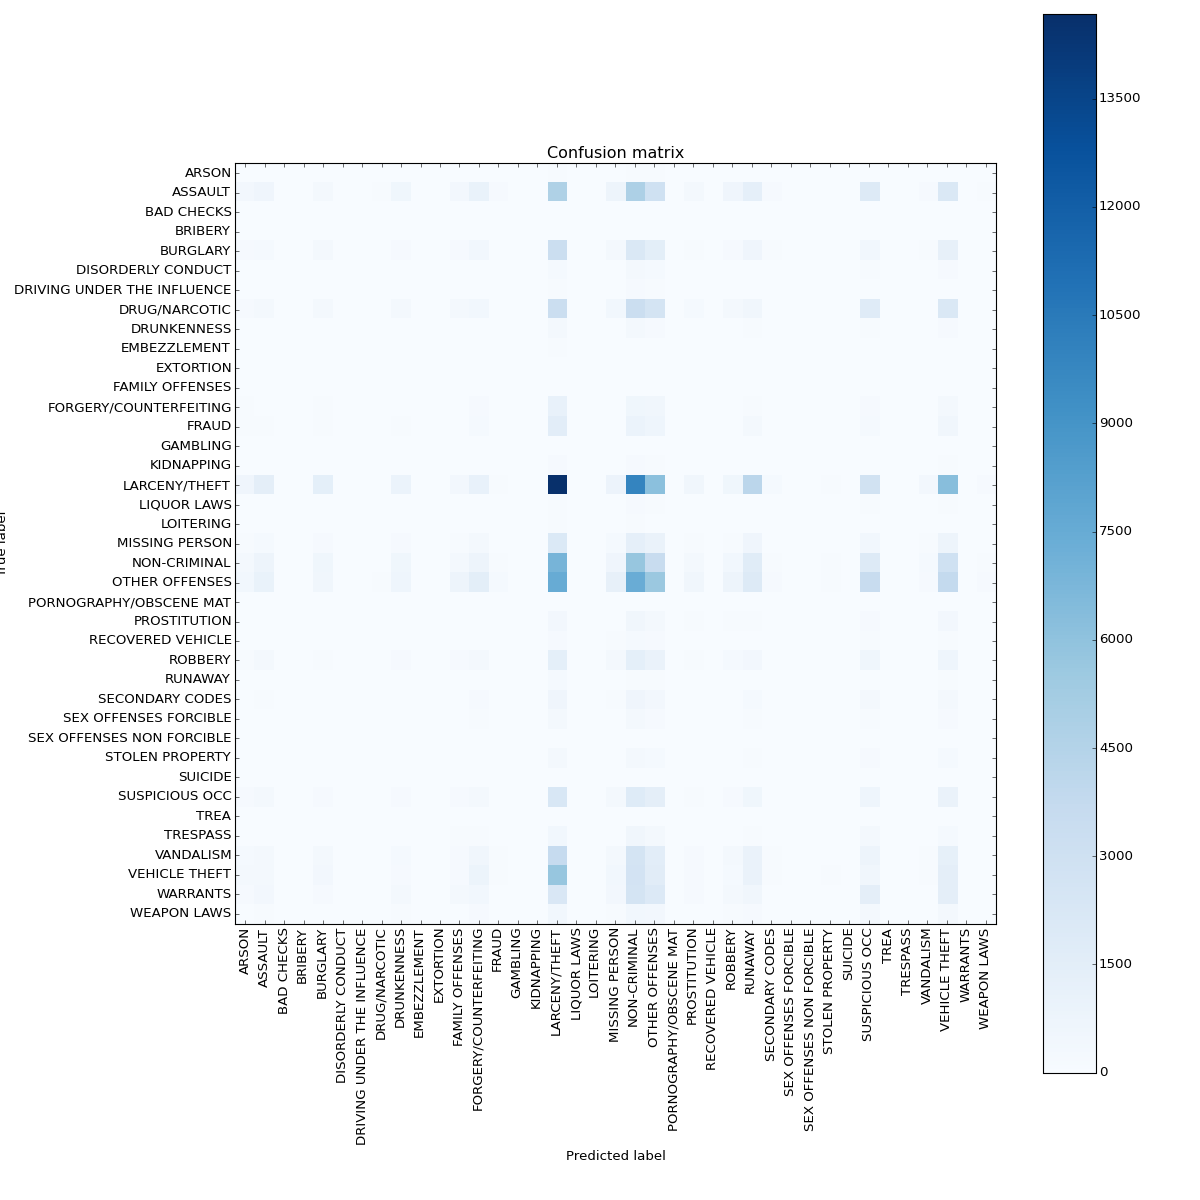

In [37]:
def plot_conf_matrix(Y_test, Y_pred):
    labels = np.unique(Y_test)
    cm = confusion_matrix(Y_test, Y_pred, labels)
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_conf_matrix(Y_test, Y_pred)

263415